In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import cProfile
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cross_validation import train_test_split
from __future__ import division
import itertools

In [80]:
def dataset_fixed_cov():
    '''Generate 2 Gaussians samples with the same covariance matrix'''
    n, dim = 500, 2
    np.random.seed(0)
    #C = np.array([[0., -0.23], [0.83, .23]])
    C = np.array([[0.,-0.23],[0.5,0.23]])
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C) + np.array([1, 1])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

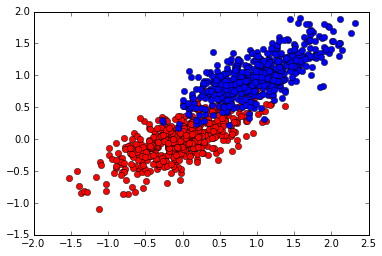

In [81]:
X,y = dataset_fixed_cov()
plt.figure()
plt.plot(X[0:500, 0], X[0:500, 1], 'o', color='red')
plt.plot(X[500:999, 0], X[500:999, 1], 'o', color='blue')


In [82]:
def dataset_cov():
    '''Generate 2 Gaussians samples with different covariance matrices'''
    n, dim = 300, 2
    np.random.seed(0)
    C = np.array([[0., -1.], [2.5, .7]]) * 2.
    print C
    X = np.r_[np.dot(np.random.randn(n, dim), C),
              np.dot(np.random.randn(n, dim), C.T) + np.array([1, 4])]
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

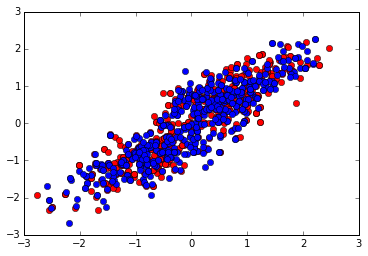

In [83]:
random_num = np.random.randint(X.shape[0], size = X.shape[0])
random_number = 11232015
rng = np.random.RandomState(random_number)
permutation1 = rng.permutation(len(random_num))
random_num = random_num[permutation1]
X = X[random_num]
y = y[random_num]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5,random_state=11)
X_train = preprocessing.scale(X_train,axis = 0, with_mean=True, with_std=True)
X_test = preprocessing.scale(X_test,axis = 0, with_mean=True, with_std=True)
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
y_train = min_max_scaler.fit_transform(y_train)
y_test = min_max_scaler.fit_transform(y_test)

plt.figure()
plt.plot(X_train[:, 0], X_train[:, 1], 'o', color='red')
plt.plot(X_test[:, 0], X_test[:, 1], 'o', color='blue')


In [84]:
ones = np.ones((X_train.shape[0]))
ones = np.mat(ones).T
X_train = np.concatenate((X_train,ones),axis=1)
ones = np.ones((X_test.shape[0]))
ones = np.mat(ones).T
X_test = np.concatenate((X_test,ones),axis=1)
print X_train

[[-1.56105686 -0.68966361  1.        ]
 [ 0.47679761  0.0673433   1.        ]
 [-0.74202249 -0.23785172  1.        ]
 ..., 
 [ 1.3965502   1.71082903  1.        ]
 [ 1.61006469  1.11429946  1.        ]
 [ 1.82126915  1.4153125   1.        ]]


In [85]:
def f_x(w,x):
    return np.dot(w,np.transpose(x))

def get_hinge(y,w,x):
    #t = np.dot(w,x)
    t = np.dot(w,np.transpose(x))
    return np.max(0, 1 - (y * t))

def get_huber_hinge(y,w,x,h):
    #print w
    #print x
    t = np.dot(w,np.transpose(x))
    #print t
    if((y * t) > ( 1 + h)):
        return 0
    elif (abs(1 - (y * t)) <= h):
        return ((( 1 + h - (y * t)) ** 2) / (4 * h))
    elif ((y * t) < (1 - h)):
        return (1 - (y*t))
    else:
        return 0
    
def grad_hinge(y,w,x):
    t = np.dot(w,np.transpose(x))   
    if(y * t) < 1:
        return -1 * (np.multiply(y,x))
    else:
        if (y * t) > 1:
            return 0

def grad_huber_hinge(y,w,x,h):
    t = np.dot(w,np.transpose(x))  
    if (y * t) > ( 1 + h):
        return 0
    elif (abs(1 - (y * t)) <= h):
        denominator = np.multiply(y,x) / (2 * h)
        val = (y * t) + (1 + h)
        return np.multiply(denominator,val)
    elif (y * t) < (1 - h):
        return -1 * (np.multiply(y,x))
    else:
        return 0
    

In [86]:
def obj_huber_hinge(y,w,X_in,h):
    w_2 = np.linalg.norm(w) ** 2
    loss = np.zeros((X_in.shape[0]))
    for i in range(X_in.shape[0]):
        loss[i] = get_huber_hinge(y[i],w,X_in[i],h)
    tot_loss = np.sum((loss))    
    return (w_2 + ((1/X_in.shape[0]) * tot_loss))
    

In [87]:
def obj_grad_huber_hinge(y,w,X_in,h):
    w_2 = np.multiply(2,w)
    loss = np.zeros((X_in.shape[0],w.shape[1]))
    for i in range(X_in.shape[0]):
        loss[i] = grad_huber_hinge(y[i],w,X_in[i],h)
    tot_loss = np.sum((loss),axis = 0)
    tmp = 1 / X_in.shape[0]
    tot_loss = np.multiply(tmp,tot_loss)
    return np.add(w_2 , tot_loss)

In [88]:
def compute_obj(w,X_in,y,h):
    return obj_huber_hinge(y,w,X_in,h)
def compute_grad(w,X_in,y,h):
    return obj_grad_huber_hinge(y,w,X_in,h)
def update_theta(w,ita,grad):
    #tmp = 1 / np.linalg.norm(grad)
    #u_grad = np.multiply(tmp,grad)
    #ita = -1 * ita
    w = w - ita * grad
    #w = np.add(w,np.multiply(ita,u_grad))
    return w  

def line_search(C,tau,alpha,grad,w,X,y,h):
    j = 0
    prev_alpha = alpha
    a = [1, 2, 3]
    for element in itertools.cycle(a): 
        if j > 1:
            return alpha
        #tmp = 1 / np.linalg.norm(grad)
        #p = np.multiply(tmp,grad)
        p = -1 * grad
        #print grad
        #print p
        m = np.dot(p,np.transpose(grad))
        t = -1 * C * m
        
        alpha_p = np.multiply(alpha,p)
        new_w = np.add(w,alpha_p)
        alpha_t = alpha * t
        if ((compute_obj(w,X,y,h) - compute_obj(new_w,X,y,h)) >= alpha_t):
            return alpha
        else:
            prev_alpha = alpha
            alpha = tau * prev_alpha
        j = j + 1

In [89]:
def my_gradient_descent(y_in,X_in,y_test,X_test,ita,t,stop_cr):
    w = np.zeros((X_in.shape[1]))
    w = np.matrix(w)
    w_t = np.zeros((t))
    w_t_w = np.zeros((t,X_in.shape[1]))
    train_error = np.zeros((t))
    test_error = np.zeros((t))
    num_iter = t;
    val_error = np.zeros((t))
    
    for i in range(t):
        w_t_w[i] = w
        w_t[i] = compute_obj(w,X_in,y_in,0.2)
        grad = compute_grad(w,X_in,y_in,0.2)
        if stop_cr == 2:
            if np.linalg.norm(grad) <= 0.001:
                num_iter = i
                break
                
        new_ita = line_search(0.5,0.3,ita,grad,w,X_in,y_in,0.2)
        #print new_ita
        w = update_theta(w,new_ita,grad)
        
        
        #plots:
        g_x_train = np.sign(np.dot(w,np.transpose(X_in)))
        error_train = np.multiply(y_in,g_x_train)
        wrong_mask_train = error_train <= 0
        tr_er_score =  np.sum(wrong_mask_train) / X_in.shape[0] 
        train_error[i] = tr_er_score 
        
        g_x_test = np.sign(np.dot(w,np.transpose(X_test)))
        error_test = np.multiply(y_test,g_x_test)
        wrong_mask_test = error_test <= 0
        tt_er_score =  np.sum(wrong_mask_test) / X_test.shape[0] 
        test_error[i] = tt_er_score
        
        random_num = np.random.randint(X_in.shape[0], size = 100)
        random_number = 11232015
        rng = np.random.RandomState(random_number)
        permutation1 = rng.permutation(len(random_num))
        random_num = random_num[permutation1]
        val_in = X_in[random_num]
        val_y = y_in[random_num]
        g_x_val = np.sign(np.dot(w,np.transpose(val_in)))
        error_val = np.multiply(val_y,g_x_val)
        wrong_mask_val = error_val <= 0
        vl_er_score =  np.sum(wrong_mask_val) / val_in.shape[0] 
        val_error[i] = vl_er_score 
        
        if stop_cr == 3:
            if i > 10:
                tmp_error = val_error[i - 10 : i - 1]
                print tmp_error
                val = np.amin(tmp_error)
                print val
                if val_error[i] > 0.9 * val:
                    num_iter = i
                    break
        
        #print w
    #tmp = 1 / t
    #print tmp
    #print w_t
    
    plt.plot(np.arange(w_t.shape[0]),w_t,'r',linewidth=2.5, linestyle="-",label = 'Obective function')
    plt.xlabel("Iterations")
    plt.ylabel("Objective function")
    plt.title("Gradient Descent with Line Search")
    plt.legend(loc='upper right')
    plt.show()
    
    
    
    plt.plot(np.arange(train_error.shape[0]),train_error,'c',linewidth=2.5, linestyle="-",label = 'train error')
    plt.plot(np.arange(test_error.shape[0]),test_error,'g',linewidth=2.5, linestyle="-",label = 'test error')

    plt.xlabel("Iterations")
    plt.ylabel("% Misclassification Error")
    plt.title("Gradient Descent with Line Search")
    plt.legend(loc='upper right')
    plt.show()
    
    
    
    if(stop_cr == 1):
        index = np.argmin(w_t)
    else:
        index = np.argmin(w_t[0:num_iter]) 
    print index
    print w_t[index]
    return w_t_w[index]
    #return np.multiply(tmp,np.sum((w_t),axis = 0))
    

In [90]:
def my_svm(X_in,y_in,X_test,y_test,stop_cr):
    max_iter = 1000
    ita = 1
    w = my_gradient_descent(y_in,X_in,y_test,X_test,ita,max_iter,stop_cr)  
    print w
    #print X_test
    #print y_in

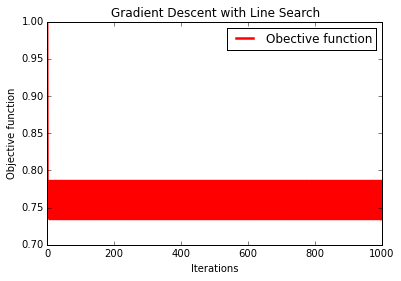

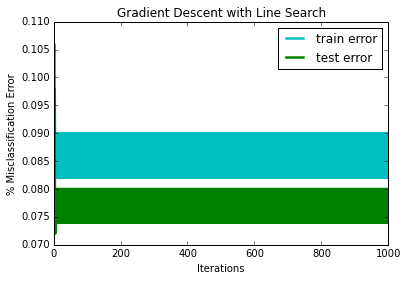

7
0.734553589475
[ 0.23012182  0.30628318  0.01420407]
--- 129.495651007 seconds for my_svm---


In [91]:
start_time = time.time()
my_svm(X_train,y_train,X_test,y_test,2)
print("--- %s seconds for my_svm---" % (time.time() - start_time))